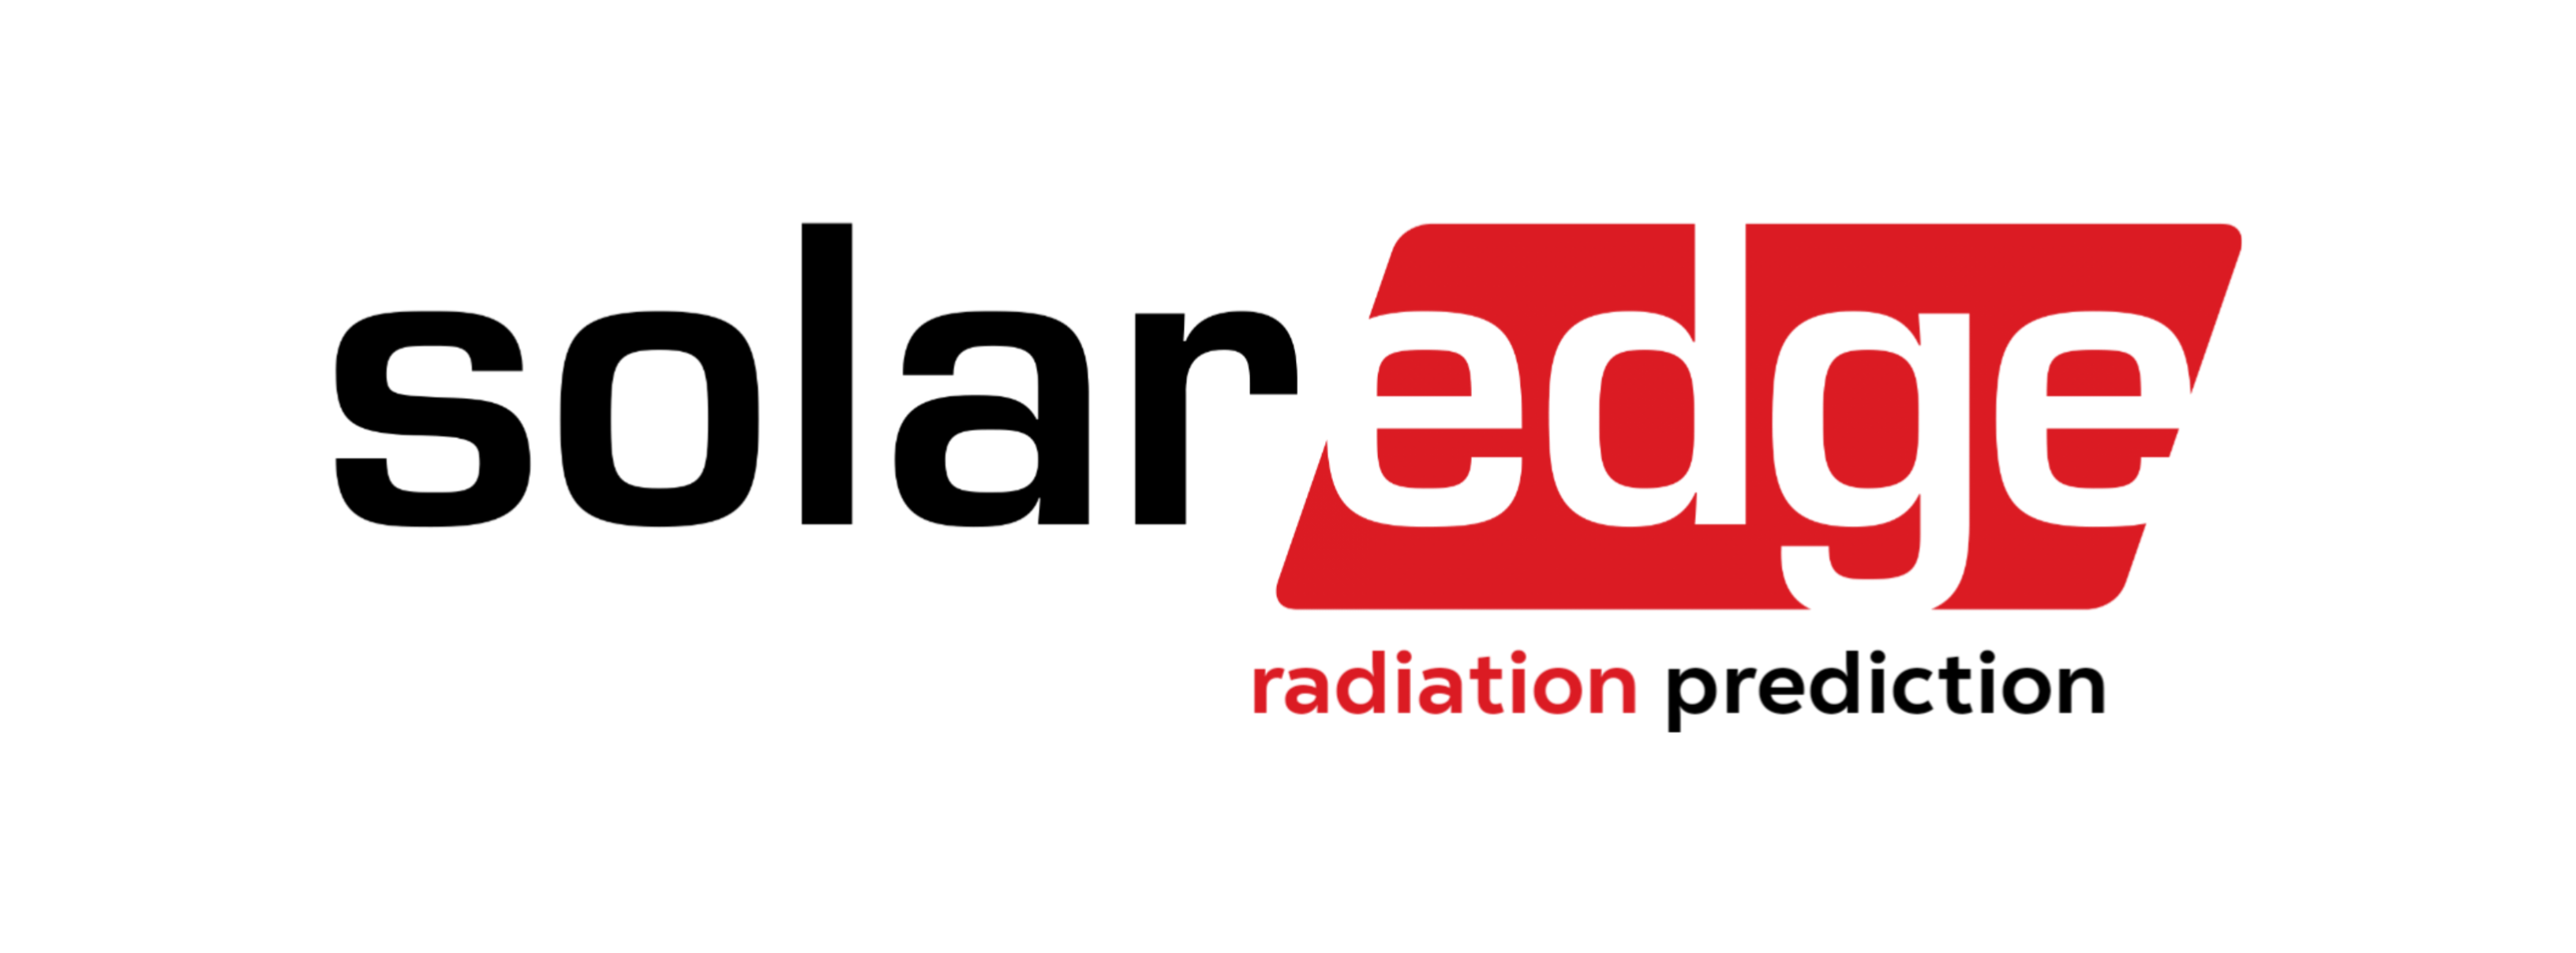

## SolarEdge Radiation Prediction Machine Learning Project

##### Project By : PRASAD JADHAV

In [74]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import xgboost as xgb
import optuna

from xgboost import XGBRegressor

from sklearn.metrics import r2_score

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [76]:
dataset = pd.read_csv('solar_radiation.csv')
dataset.shape

(32686, 11)

In [77]:
dataset.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [16]:
dataset.tail()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00
32685,1480586402,12/1/2016 12:00:00 AM,00:00:02,1.20,44,30.43,101,83.59,3.37,06:41:00,17:42:00


In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [18]:
dataset.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [19]:
dataset.duplicated().sum()

0

In [20]:
dataset.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


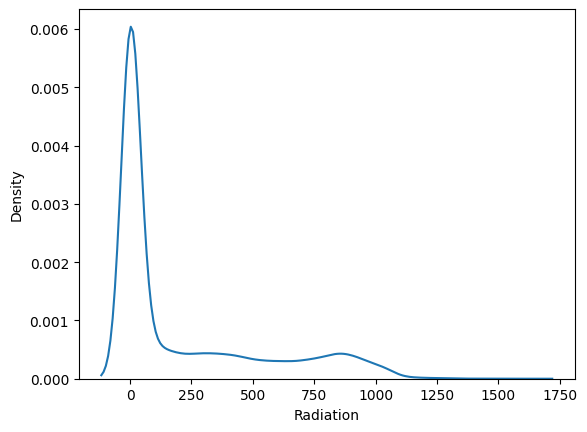

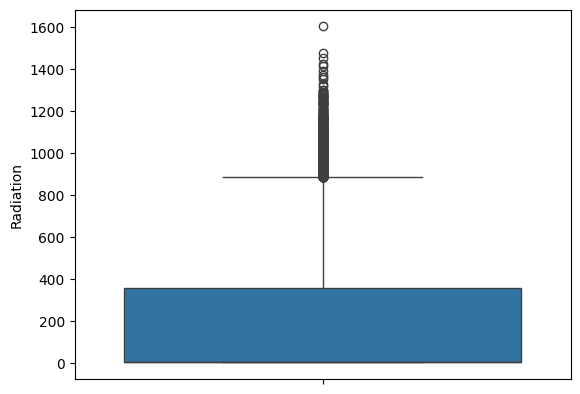

In [21]:
sns.kdeplot(dataset['Radiation'])
plt.show()
sns.boxplot(dataset['Radiation'])
plt.show()

### Feature Engineering

In [78]:
dataset['Month'] = dataset['Data'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
dataset['Day'] = dataset['Data'].apply(lambda x: re.search(r'(?<=\/)\d+(?=\/)', x).group(0)).astype(np.int)
dataset['Year'] = dataset['Data'].apply(lambda x: re.search(r'(?<=\/)\d+(?=\s)', x).group(0)).astype(np.int)

dataset = dataset.drop('Data', axis=1)

In [79]:
dataset['Hour'] = dataset['Time'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
dataset['Minute'] = dataset['Time'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)', x).group(0)).astype(np.int)
dataset['Second'] = dataset['Time'].apply(lambda x: re.search(r'\d+$', x).group(0)).astype(np.int)

dataset = dataset.drop('Time', axis=1)

In [80]:
dataset['SunriseHour'] = dataset['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
dataset['SunriseMinute'] = dataset['TimeSunRise'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)', x).group(0)).astype(np.int)

dataset['SunsetHour'] = dataset['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
dataset['SunsetMinute'] = dataset['TimeSunSet'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)', x).group(0)).astype(np.int)

dataset = dataset.drop(['TimeSunRise', 'TimeSunSet'], axis=1)

In [81]:
dataset.dtypes

UNIXTime                    int64
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
Month                       int32
Day                         int32
Year                        int32
Hour                        int32
Minute                      int32
Second                      int32
SunriseHour                 int32
SunriseMinute               int32
SunsetHour                  int32
SunsetMinute                int32
dtype: object

In [82]:
dataset['Year'].unique()

array([2016])

In [83]:
dataset['SunriseHour'].unique()

array([6])

In [84]:
dataset = dataset.drop(['Year', 'SunriseHour'], axis=1)

In [85]:
df = dataset.copy()

### Splitting/Scaling

In [86]:
X = df.drop('Radiation', axis=1)
y = df['Radiation']

In [87]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=200)

In [89]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

### Hyperparameter Search

In [90]:
def get_model_rmse(params):
    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=0)
    results = model.eval(dval)
    rmse = np.float(re.search(r'[\d.]+$', results).group(0))
    return rmse

In [91]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.00001, 10.0)
    max_depth = trial.suggest_int('max_depth', 4, 8)
    l1_reg = trial.suggest_loguniform('l1_reg', 0.00001, 10.0)
    l2_reg = trial.suggest_loguniform('l2_reg', 0.00001, 10.0)
    
    params = {'learning_rate': learning_rate, 'max_depth': max_depth, 'alpha': l1_reg, 'lambda': l2_reg}
    
    return get_model_rmse(params)

In [92]:
study = optuna.create_study()
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-06-04 11:39:07,320] A new study created in memory with name: no-name-b6b497ed-2e7c-4893-93b0-d44bc34c7652


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-04 11:39:07,730] Trial 0 finished with value: 286.23890284318173 and parameters: {'learning_rate': 0.0014513643449605962, 'max_depth': 4, 'l1_reg': 0.0011715693193685467, 'l2_reg': 5.461063526105314e-05}. Best is trial 0 with value: 286.23890284318173.
[I 2024-06-04 11:39:08,240] Trial 1 finished with value: 316.960772355036 and parameters: {'learning_rate': 9.222111768125214e-05, 'max_depth': 6, 'l1_reg': 0.0007415159978172381, 'l2_reg': 1.9730074185369947e-05}. Best is trial 0 with value: 286.23890284318173.
[I 2024-06-04 11:39:09,105] Trial 2 finished with value: 316.70937552112355 and parameters: {'learning_rate': 9.854387439411111e-05, 'max_depth': 8, 'l1_reg': 0.025321305058033653, 'l2_reg': 0.38302866451514384}. Best is trial 0 with value: 286.23890284318173.
[I 2024-06-04 11:39:09,474] Trial 3 finished with value: 310.33897706066415 and parameters: {'learning_rate': 0.00037347196863932934, 'max_depth': 4, 'l1_reg': 0.001430350882075482, 'l2_reg': 0.7366524148621565}.

[I 2024-06-04 11:39:26,385] Trial 32 finished with value: 106.67274318964803 and parameters: {'learning_rate': 0.018580812012910782, 'max_depth': 8, 'l1_reg': 3.14746360064796, 'l2_reg': 0.29631564842113894}. Best is trial 21 with value: 87.50635331432473.
[I 2024-06-04 11:39:27,191] Trial 33 finished with value: 87.015788597796 and parameters: {'learning_rate': 0.1205448070519847, 'max_depth': 8, 'l1_reg': 0.08724048591319947, 'l2_reg': 5.5884014748370435e-05}. Best is trial 33 with value: 87.015788597796.
[I 2024-06-04 11:39:27,889] Trial 34 finished with value: 86.83392245885695 and parameters: {'learning_rate': 0.12674318578537933, 'max_depth': 8, 'l1_reg': 0.06101289363883993, 'l2_reg': 0.00026286248272275553}. Best is trial 34 with value: 86.83392245885695.
[I 2024-06-04 11:39:28,568] Trial 35 finished with value: 89.52815011551132 and parameters: {'learning_rate': 0.23201479932344848, 'max_depth': 8, 'l1_reg': 0.005206857357422524, 'l2_reg': 5.181440817988569e-05}. Best is trial

[I 2024-06-04 11:39:47,244] Trial 64 finished with value: 86.37624888966442 and parameters: {'learning_rate': 0.1817464287268423, 'max_depth': 8, 'l1_reg': 0.015294852058253752, 'l2_reg': 3.5160552815973834e-05}. Best is trial 64 with value: 86.37624888966442.
[I 2024-06-04 11:39:48,253] Trial 65 finished with value: 87.83693204238838 and parameters: {'learning_rate': 0.09043789201568411, 'max_depth': 8, 'l1_reg': 0.011699284844604167, 'l2_reg': 0.0006213777561901947}. Best is trial 64 with value: 86.37624888966442.
[I 2024-06-04 11:39:48,587] Trial 66 finished with value: 93.92284011755166 and parameters: {'learning_rate': 0.5149961602048274, 'max_depth': 8, 'l1_reg': 0.013607972298333501, 'l2_reg': 0.025567932673158766}. Best is trial 64 with value: 86.37624888966442.
[I 2024-06-04 11:39:49,061] Trial 67 finished with value: 90.14233773005024 and parameters: {'learning_rate': 0.17068393404299173, 'max_depth': 7, 'l1_reg': 3.040090753052395e-05, 'l2_reg': 0.0017023778834128751}. Best 

[I 2024-06-04 11:40:09,116] Trial 96 finished with value: 87.31678706123066 and parameters: {'learning_rate': 0.1441191970185773, 'max_depth': 8, 'l1_reg': 3.0192333425456317e-05, 'l2_reg': 2.368936641463794e-05}. Best is trial 64 with value: 86.37624888966442.
[I 2024-06-04 11:40:10,196] Trial 97 finished with value: 120.69471836305118 and parameters: {'learning_rate': 0.014692115769466671, 'max_depth': 8, 'l1_reg': 0.00014092873351356094, 'l2_reg': 6.042057292536316e-05}. Best is trial 64 with value: 86.37624888966442.
[I 2024-06-04 11:40:11,247] Trial 98 finished with value: 89.24689708192244 and parameters: {'learning_rate': 0.043363553208971985, 'max_depth': 8, 'l1_reg': 0.0005431953254730441, 'l2_reg': 0.017759757458948068}. Best is trial 64 with value: 86.37624888966442.
[I 2024-06-04 11:40:12,164] Trial 99 finished with value: 86.79392363219999 and parameters: {'learning_rate': 0.07934676943163349, 'max_depth': 8, 'l1_reg': 0.005888070354397567, 'l2_reg': 0.33977177075596793}. 

In [93]:
best_params = study.best_params
best_params

{'learning_rate': 0.1817464287268423,
 'max_depth': 8,
 'l1_reg': 0.015294852058253752,
 'l2_reg': 3.5160552815973834e-05}

In [94]:
model = xgb.train(best_params, dtrain, num_boost_round=10000, evals=[(dval, 'eval')], early_stopping_rounds=10)

[0]	eval-rmse:269.52015
[1]	eval-rmse:229.55911
[2]	eval-rmse:197.38242
[3]	eval-rmse:172.03148
[4]	eval-rmse:152.71101
[5]	eval-rmse:137.90114
[6]	eval-rmse:126.34585
[7]	eval-rmse:117.34834
[8]	eval-rmse:110.35455
[9]	eval-rmse:104.89189
[10]	eval-rmse:101.31197
[11]	eval-rmse:98.43331
[12]	eval-rmse:96.29094
[13]	eval-rmse:94.58938
[14]	eval-rmse:92.90102
[15]	eval-rmse:91.94923
[16]	eval-rmse:90.94863
[17]	eval-rmse:90.70197
[18]	eval-rmse:90.24344
[19]	eval-rmse:90.15040
[20]	eval-rmse:89.79977
[21]	eval-rmse:89.61078
[22]	eval-rmse:89.38205
[23]	eval-rmse:89.05413
[24]	eval-rmse:88.88187
[25]	eval-rmse:88.85639
[26]	eval-rmse:88.72534
[27]	eval-rmse:88.68539
[28]	eval-rmse:88.67129
[29]	eval-rmse:88.54316
[30]	eval-rmse:88.47315
[31]	eval-rmse:88.49847
[32]	eval-rmse:88.35502
[33]	eval-rmse:88.19842
[34]	eval-rmse:88.14295
[35]	eval-rmse:88.05461
[36]	eval-rmse:87.86823
[37]	eval-rmse:87.92946
[38]	eval-rmse:87.76285
[39]	eval-rmse:87.67317
[40]	eval-rmse:87.38159
[41]	eval-rmse:

### Results

In [95]:
y_true = np.array(y_test, dtype=np.float)
y_pred = np.array(model.predict(dtest), dtype=np.float)

In [96]:
r2 = r2_score(y_true, y_pred)

print("R^2 Score: {:.4f}".format(r2))

R^2 Score: 0.9380


#### Experiment Tracking > Model > Validation > Development > Validation > Prediction

In [64]:
from sklearn.datasets import make_regression

# Generate synthetic data
X, y = make_regression(n_samples=1000, n_features=20, n_informative=10, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBClassifier with default hyperparameters
model = XGBRegressor(n_estimators=1500, learning_rate=0.05, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate the model on the training set
train_preds = model.predict(X_train)
train_r2_score = r2_score(y_train, train_preds)

# Evaluate the model on the testing set
test_preds = model.predict(X_test)
test_r2_score = r2_score(y_test, test_preds)

print(f"Training Score: {train_r2_score:.2f}")
print(f"Testing Score: {test_r2_score:.2f}")

Training Score: 1.00
Testing Score: 0.85


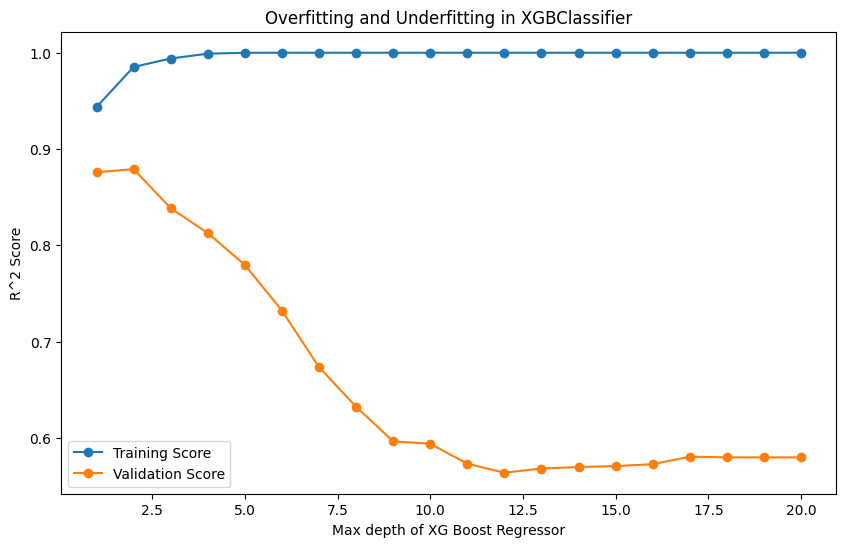

In [63]:
from sklearn.datasets import make_regression

# Generating a synthetic dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, random_state=42)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to plot overfitting and underfitting
def plot_overfitting_underfitting(X_train, y_train, X_test, y_test):
    train_r2_score = []
    test_r2_score = []
    max_depths = list(range(1, 21))
    
    for max_depth in max_depths:
        model = XGBRegressor(max_depth=max_depth, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_r2_score.append(r2_score(y_train, y_train_pred))
        test_r2_score.append(r2_score(y_test, y_test_pred))
    
    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_r2_score, label='Training Score', marker='o')
    plt.plot(max_depths, test_r2_score, label='Validation Score', marker='o')
    plt.xlabel('Max depth of XG Boost Regressor')
    plt.ylabel('R^2 Score')
    plt.title('Overfitting and Underfitting in XGBClassifier')
    plt.legend()
    plt.show()

# Plotting
plot_overfitting_underfitting(X_train, y_train, X_test, y_test)

#### Bias-Variance Trade Off

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1}
Best Score (RMSE): 79.31992022234765
[0]	validation_0-rmse:302.31841	validation_1-rmse:301.56061
[1]	validation_0-rmse:289.33684	validation_1-rmse:288.73636
[2]	validation_0-rmse:277.01532	validation_1-rmse:276.57029
[3]	validation_0-rmse:265.39863	validation_1-rmse:265.02844
[4]	validation_0-rmse:254.49285	validation_1-rmse:254.30774
[5]	validation_0-rmse:243.93631	validation_1-rmse:243.90722
[6]	validation_0-rmse:234.16603	validation_1-rmse:234.27858
[7]	validation_0-rmse:224.78826	validation_1-rmse:225.10627
[8]	validation_0-rmse:215.93850	validation_1-rmse:216.41120
[9]	validation_0-rmse:207.62265	validation_1-rmse:208.26476
[10]	validation_0-rmse:199.72204	validation_1-rmse:200.53446
[11]	validation_0-rmse:192.36495	validation_1-rmse

[133]	validation_0-rmse:64.40969	validation_1-rmse:83.45645
[134]	validation_0-rmse:64.23348	validation_1-rmse:83.45429
[135]	validation_0-rmse:64.18416	validation_1-rmse:83.44729
[136]	validation_0-rmse:64.00847	validation_1-rmse:83.40194
[137]	validation_0-rmse:63.91113	validation_1-rmse:83.37671
[138]	validation_0-rmse:63.77956	validation_1-rmse:83.32642
[139]	validation_0-rmse:63.70773	validation_1-rmse:83.28543
[140]	validation_0-rmse:63.59932	validation_1-rmse:83.29271
[141]	validation_0-rmse:63.50726	validation_1-rmse:83.26707
[142]	validation_0-rmse:63.42856	validation_1-rmse:83.20604
[143]	validation_0-rmse:63.36540	validation_1-rmse:83.19443
[144]	validation_0-rmse:63.19847	validation_1-rmse:83.14096
[145]	validation_0-rmse:63.10934	validation_1-rmse:83.10980
[146]	validation_0-rmse:63.03131	validation_1-rmse:83.16045
[147]	validation_0-rmse:62.89068	validation_1-rmse:83.08938
[148]	validation_0-rmse:62.75444	validation_1-rmse:83.05733
[149]	validation_0-rmse:62.56382	validat

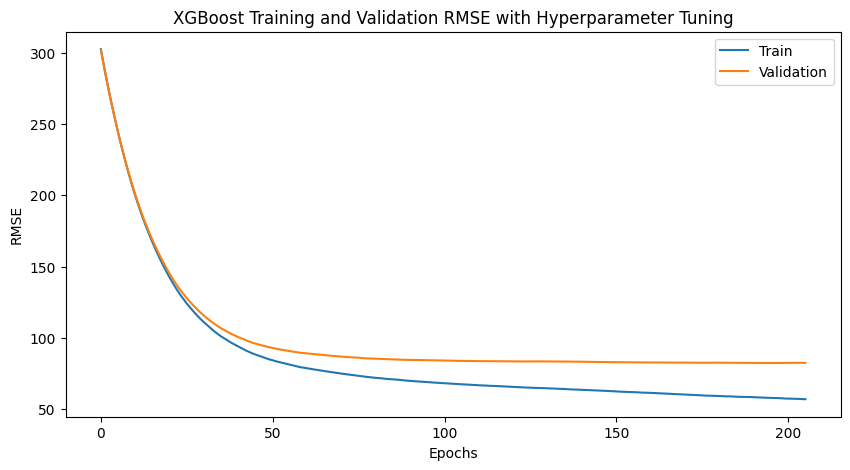

In [123]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Generate a sample regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(b_X, b_y, test_size=0.2, random_state=42)

# Set up the parameter grid for XGBoost regression
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1],
    'subsample': [0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1, 1.5, 2],
    'reg_lambda': [0, 0.1, 0.5, 1, 1.5, 2],
    'min_child_weight': [1, 3, 5, 7]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Set up the RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=param_grid,
                                   n_iter=100, scoring='neg_mean_squared_error', cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score (RMSE): {np.sqrt(-random_search.best_score_)}")

# Train the final model with the best parameters
best_params = random_search.best_params_
b_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
eval_set = [(X_train, y_train), (X_val, y_val)]
b_model.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Make predictions
y_train_pred = b_model.predict(X_train)
y_val_pred = b_model.predict(X_val)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)

train_rmse = np.sqrt(train_mse)
val_rmse = np.sqrt(val_mse)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Print the evaluation metrics
print("Train Scores:")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nValidation Scores:")
print(f"MAE: {val_mae:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R²: {val_r2:.4f}")

# Plot the training and validation RMSE
results = b_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost Training and Validation RMSE with Hyperparameter Tuning')
plt.show()

#### Prediction

In [136]:
print('Enter The Solar Details')

unixtime = int(input('Enter the UNIXTime: '))
temperature = int(input('Enter the Temperature: '))
pressure = float(input('Enter the Pressure: '))
humidity = int(input('Enter the Humidity: '))
winddirection_dgr = float(input('Enter the WindDirection(Degrees): '))
speed = float(input('Enter the Speed: '))
month = int(input('Enter the Month: '))
day = int(input('Enter the Day: '))
h = int(input('Enter the Hour: '))
m = int(input('Enter the Minute: '))
s = int(input('Enter the Second: '))
srm = int(input('Enter the Sunrise Minute: '))
ssh = int(input('Enter the Sunset Hour: '))
ssm = int(input('Enter the Sunset Minute: '))

input_point = np.array([[unixtime, temperature, pressure, humidity, winddirection_dgr, speed, month, day, h, m, s, srm, ssh, ssm]])

# Convert the input data to DMatrix
dinput_point = xgb.DMatrix(input_point)

# Assuming x_model is your trained XGBoost model
prediction = x_model.predict(dinput_point)

print(f'The Radiation Prediction result is: {prediction[0]}')

Enter The Solar Details
Enter the UNIXTime: 1483030843
Enter the Temperature: 43
Enter the Pressure: 30.35
Enter the Humidity: 101
Enter the WindDirection(Degrees): 116.93
Enter the Speed: 4.5
Enter the Month: 12
Enter the Day: 29
Enter the Hour: 7
Enter the Minute: 0
Enter the Second: 43
Enter the Sunrise Minute: 56
Enter the Sunset Hour: 17
Enter the Sunset Minute: 53
The Radiation Prediction result is: 142.3286590576172


#### Dump/Load Model

In [145]:
import pickle

# DMatrix Xmodel
pickle.dump(x_model,open('x_solar_predictor.pkl','wb'))
x_model = pickle.load(open('x_solar_predictor.pkl','rb'))

In [146]:
# Normal Model
pickle.dump(b_model,open('b_solar_predictor.pkl','wb'))
b_model = pickle.load(open('b_solar_predictor.pkl','rb'))

In [149]:
print(df.sample(1))

        UNIXTime  Radiation  Temperature  Pressure  Humidity  \
9122  1477481720       1.21           46     30.43        46   

      WindDirection(Degrees)  Speed  Month  Day  Hour  Minute  Second  \
9122                  140.93    4.5     10   26     1      35      20   

      SunriseMinute  SunsetHour  SunsetMinute  
9122             21          17            52  


In [154]:
print('Enter The Solar Details')

unixtime = int(input('Enter the UNIXTime: '))
temperature = int(input('Enter the Temperature: '))
pressure = float(input('Enter the Pressure: '))
humidity = int(input('Enter the Humidity: '))
winddirection_dgr = float(input('Enter the WindDirection(Degrees): '))
speed = float(input('Enter the Speed: '))
month = int(input('Enter the Month: '))
day = int(input('Enter the Day: '))
h = int(input('Enter the Hour: '))
m = int(input('Enter the Minute: '))
s = int(input('Enter the Second: '))
srm = int(input('Enter the Sunrise Minute: '))
ssh = int(input('Enter the Sunset Hour: '))
ssm = int(input('Enter the Sunset Minute: '))

input_point = np.array([[unixtime, temperature, pressure, humidity, winddirection_dgr, speed, month, day, h, m, s, srm, ssh, ssm]])

# Convert the input data to DMatrix
dinput_point = xgb.DMatrix(input_point)

# Assuming x_model is your trained XGBoost model
prediction = x_model.predict(dinput_point)

print(f'The Radiation Prediction result is: {prediction[0]}')

Enter The Solar Details
Enter the UNIXTime: 1477481720
Enter the Temperature: 46
Enter the Pressure: 30.43
Enter the Humidity: 46
Enter the WindDirection(Degrees): 140.93
Enter the Speed: 4.5
Enter the Month: 10
Enter the Day: 26
Enter the Hour: 1
Enter the Minute: 35
Enter the Second: 20
Enter the Sunrise Minute: 21
Enter the Sunset Hour: 17
Enter the Sunset Minute: 52
The Radiation Prediction result is: 1.8478946685791016


In [155]:
# x_model prediction result: 153.34188842773438
# b_model prediction result: 1.8478946685791016

##### Thank You!